Trees

In [1]:
import os
import re
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import warnings

In [51]:
os.getcwd()
# from thon.Choose import choose_features
from thon.churn_functions import plot_eval, bake, modernize, tree_importance
# data = choose_features("data/out/features.csv", cv_range = (0, 10), save = False)

In [3]:
# features are automatically trimmed
data = pd.read_csv("./data/out/features.csv")

In [115]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, shuffle = False)

In [117]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

In [118]:
search = GridSearchCV(pipeline,
                      {'model__ccp_alpha':np.arange(0.1, 5, 0.1),
                      'model__max_depth':np.arange(1, 5, 1)},                      
                      cv = 5,
                      scoring = 'neg_root_mean_squared_error',
                      verbose = 1)

In [119]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', DecisionTreeRegressor())]),
             param_grid={'model__ccp_alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'model__max_depth': array([1, 2, 3, 4])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [120]:
search.best_params_['model__ccp_alpha'], search.best_params_['model__max_depth']

(0.2, 3)

In [121]:
# Training data

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(ccp_alpha=search.best_params_['model__ccp_alpha'],
                                   max_depth = search.best_params_['model__max_depth']))    
])

# Train the model
model = pipeline.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data

pred_train = pd.Series(model.predict(X_train), index=X_train.index)
pred_test = pd.Series(model.predict(X_test), index=X_test.index)

74

976.3269079685748
7.232051170137591


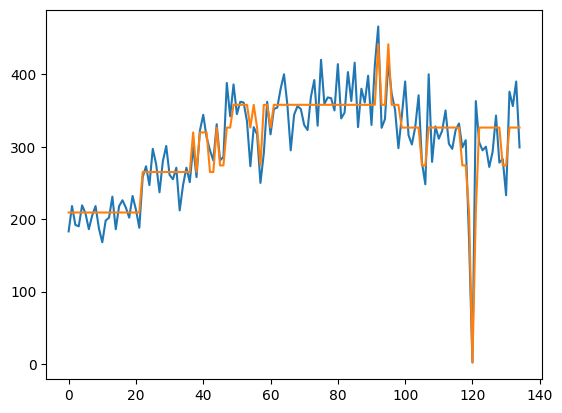

In [122]:
plot_eval(pred_train, y_train)

3984.569139203482
265.6379426135655


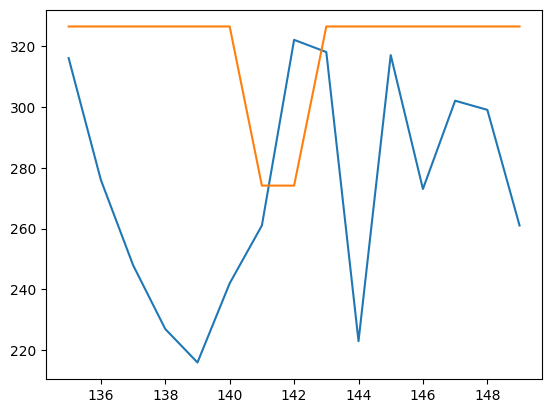

In [123]:
plot_eval(pred_test, y_test)

In [124]:
text_representation = tree.export_text(model[1], feature_names = list(X_train))

print(text_representation)

|--- laborpart_lag3 <= 0.16
|   |--- GT_lag3 <= 0.59
|   |   |--- month <= -1.16
|   |   |   |--- value: [274.11]
|   |   |--- month >  -1.16
|   |   |   |--- value: [326.39]
|   |--- GT_lag3 >  0.59
|   |   |--- HMC_v_lag3 <= -0.95
|   |   |   |--- value: [441.50]
|   |   |--- HMC_v_lag3 >  -0.95
|   |   |   |--- value: [357.82]
|--- laborpart_lag3 >  0.16
|   |--- oilimport_lag12 <= 0.72
|   |   |--- TM_lag12 <= 0.63
|   |   |   |--- value: [209.12]
|   |   |--- TM_lag12 >  0.63
|   |   |   |--- value: [2.00]
|   |--- oilimport_lag12 >  0.72
|   |   |--- TM_v_lag3 <= 0.46
|   |   |   |--- value: [265.06]
|   |   |--- TM_v_lag3 >  0.46
|   |   |   |--- value: [319.75]



In [125]:
imp = X_train.columns[model[1].feature_importances_ > 0]

In [70]:
# feature names used in model


In [106]:
# save_model(model, "treemodel.pkl")

,n
0,183
1,218
2,192
3,190
4,219
...,...
100,390
101,316
102,303
103,327


In [126]:
# predict
pred = model.predict(modernize(X_train))


In [127]:
out = bake(y_train, y_test, pred_train, pred_test, pred)

In [128]:
out.to_csv("data/out/tree.csv")